In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
df = pd.read_excel('/content/Online Retail.xlsx')
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [4]:
# Informasi dataset
print("\nInformasi dataset:")
df.info()

# Statistik deskriptif
print("\nStatistik deskriptif dataset:")
print(df.describe())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Statistik deskriptif dataset:
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:2

# Data Preprocessing

In [5]:
# Hapus baris dengan nilai CustomerID yang hilang karena ini penting untuk analisis pelanggan
df.dropna(subset=['CustomerID'], inplace=True)

# Konversi CustomerID menjadi integer
df['CustomerID'] = df['CustomerID'].astype(int)

# Hitung TotalHarga untuk setiap transaksi
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Buat fitur RFM (Recency, Frequency, Monetary)
# Recency: Berapa hari yang lalu pelanggan terakhir membeli
# Frequency: Berapa kali pelanggan membeli
# Monetary: Berapa banyak uang yang dihabiskan pelanggan

# Konversi InvoiceDate ke datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Tentukan tanggal acuan (misalnya, satu hari setelah tanggal transaksi terakhir dalam dataset)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Hitung RFM
rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
)

# Hapus baris dengan Monetary <= 0 (transaksi yang tidak relevan atau pengembalian)
rfm = rfm[rfm['Monetary'] > 0]

# Tampilkan statistik RFM
print("\nStatistik deskriptif RFM:")
print(rfm.describe())

# Normalisasi data RFM menggunakan StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)

print("\nLima baris pertama data RFM yang telah dinormalisasi:")
print(rfm_scaled_df.head())


Statistik deskriptif RFM:
           Recency    Frequency      Monetary
count  4322.000000  4322.000000  4.322000e+03
mean     90.343591     5.115687  1.923483e+03
std      99.133565     9.384459  8.263128e+03
min       1.000000     1.000000  1.776357e-15
25%      17.000000     1.000000  3.022925e+02
50%      49.500000     3.000000  6.575500e+02
75%     138.000000     6.000000  1.625740e+03
max     374.000000   248.000000  2.794890e+05

Lima baris pertama data RFM yang telah dinormalisasi:
             Recency  Frequency  Monetary
CustomerID                               
12347      -0.891260   0.200814  0.288849
12348      -0.154795  -0.118900 -0.015280
12349      -0.719755  -0.438615 -0.020084
12350       2.216019  -0.438615 -0.192332
12352      -0.548249   0.627100 -0.045760


# Pembuatan 2 Model Clustering

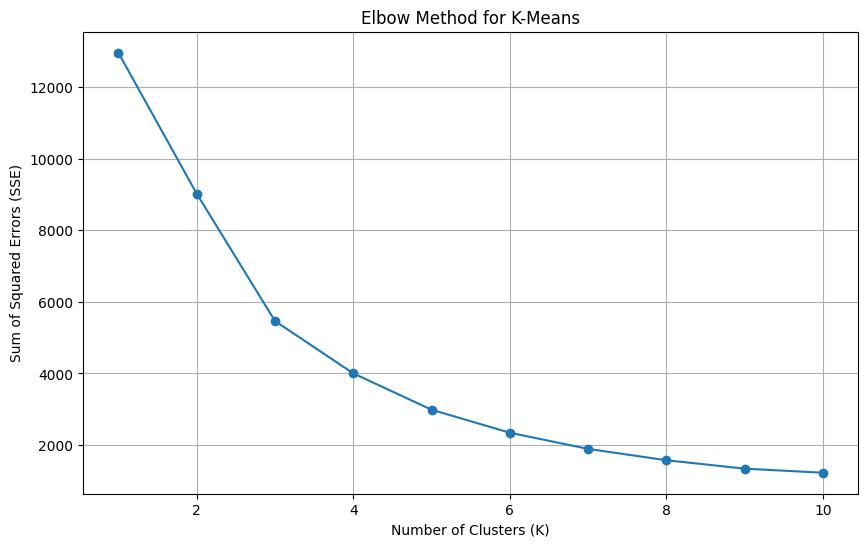

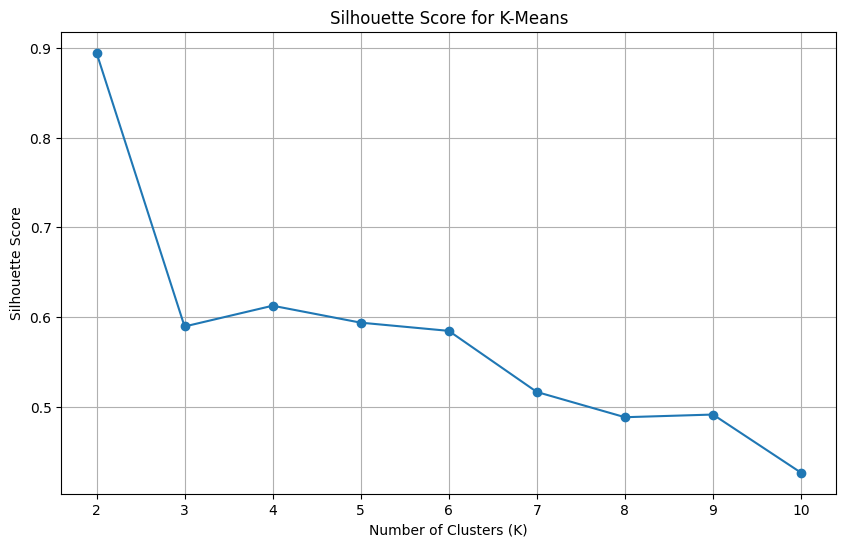


Jumlah anggota di setiap klaster K-Means (K=4):
KMeans_Cluster
0    3144
1    1062
3     110
2       6
Name: count, dtype: int64

Karakteristik klaster K-Means (rata-rata fitur asli):
                Recency  Frequency   Monetary
KMeans_Cluster                               
0                 41.14       4.82    1487.38
1                244.89       1.84     485.19
2                  7.67      89.00  182181.98
3                  9.18      40.67   18441.96


In [6]:
# K-Means Clustering
# Menentukan jumlah klaster optimal menggunakan Elbow Method

sse = [] # Sum of Squared Errors
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init diatur untuk menghindari warning
    kmeans.fit(rfm_scaled_df)
    sse.append(kmeans.inertia_) # inertia adalah SSE

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

# Menentukan jumlah klaster optimal menggunakan Silhouette Score

silhouette_scores = []
for k in range(2, 11): # Silhouette score tidak dapat dihitung untuk k=1
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for K-Means')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Berdasarkan Elbow Method dan Silhouette Score, mari kita pilih K=3 atau K=4 sebagai contoh.
# Misalkan kita pilih K=4.

optimal_k_kmeans = 4 # Anda bisa menyesuaikan ini berdasarkan plot di atas
kmeans_model = KMeans(n_clusters=optimal_k_kmeans, random_state=42, n_init=10)
rfm['KMeans_Cluster'] = kmeans_model.fit_predict(rfm_scaled_df)

print(f"\nJumlah anggota di setiap klaster K-Means (K={optimal_k_kmeans}):")
print(rfm['KMeans_Cluster'].value_counts())

print("\nKarakteristik klaster K-Means (rata-rata fitur asli):")
print(rfm.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).round(2))

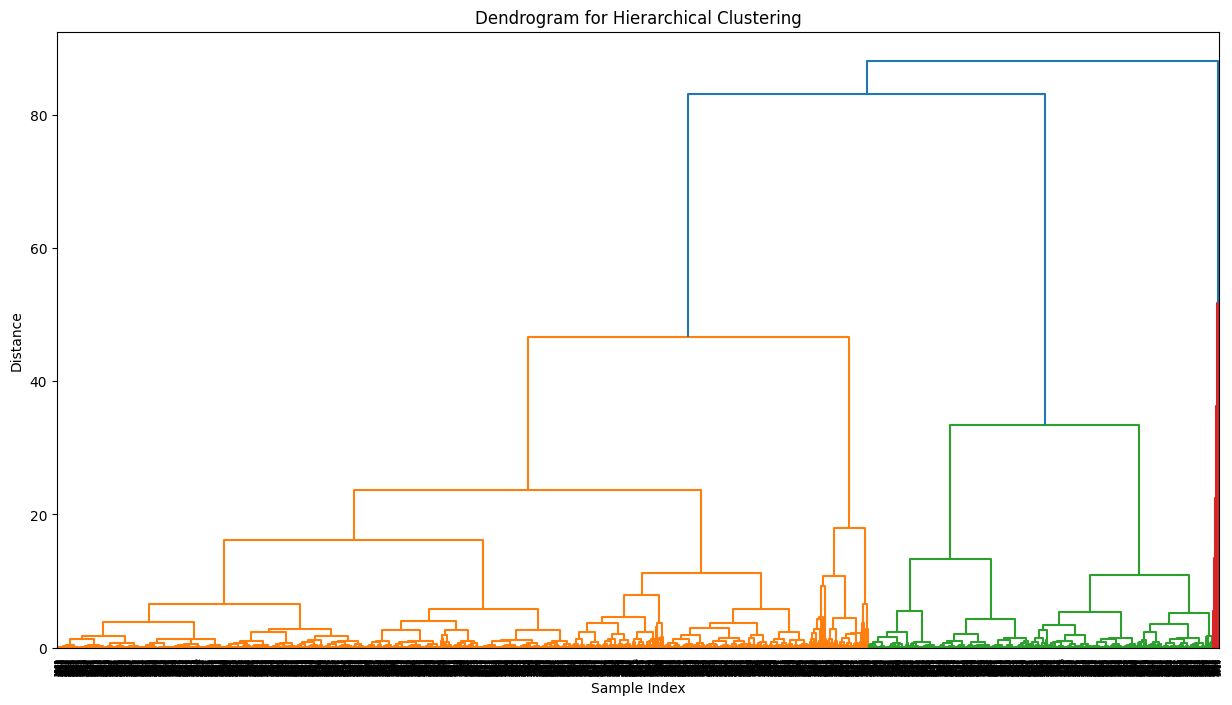


Jumlah anggota di setiap klaster Hierarchical Clustering (N_Clusters=4):
HC_Cluster
0    3017
2    1280
1      22
3       3
Name: count, dtype: int64

Karakteristik klaster Hierarchical Clustering (rata-rata fitur asli):
            Recency  Frequency   Monetary
HC_Cluster                               
0             34.34       5.76    1876.46
1              6.73      85.00   56018.83
2            223.98       2.09     543.91
3              3.67      64.67  241136.56


In [8]:
# Hierarchical Clustering
# Visualisasi Dendrogram untuk menentukan jumlah klaster

plt.figure(figsize=(15, 8))
linked = linkage(rfm_scaled_df, method='ward') # 'ward' minimizes the variance within each cluster
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Menerapkan AgglomerativeClustering
# Berdasarkan dendrogram, mari kita pilih 3 atau 4 klaster sebagai contoh.
# Misalnya kita pilih n_clusters=4.

optimal_n_clusters_hc = 4 # Sesuaikan berdasarkan dendrogram
hc_model = AgglomerativeClustering(n_clusters=optimal_n_clusters_hc, linkage='ward')
rfm['HC_Cluster'] = hc_model.fit_predict(rfm_scaled_df)

print(f"\nJumlah anggota di setiap klaster Hierarchical Clustering (N_Clusters={optimal_n_clusters_hc}):")
print(rfm['HC_Cluster'].value_counts())

print("\nKarakteristik klaster Hierarchical Clustering (rata-rata fitur asli):")
print(rfm.groupby('HC_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).round(2))

# Eksplorasi Metriks

In [10]:
# Evaluasi Metrik untuk K-Means
print("\n--- Evaluasi Metrik untuk K-Means ---")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(rfm_scaled_df)

    # Silhouette Score
    sil_score = silhouette_score(rfm_scaled_df, kmeans_labels)
    # Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(rfm_scaled_df, kmeans_labels)
    # Davies-Bouldin Index
    db_score = davies_bouldin_score(rfm_scaled_df, kmeans_labels)

    print(f"K={k}:")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Calinski-Harabasz Index: {ch_score:.4f}")
    print(f"  Davies-Bouldin Index: {db_score:.4f}")

# Evaluasi Metrik untuk Hierarchical Clustering
print("\n--- Evaluasi Metrik untuk Hierarchical Clustering ---")
for n_c in range(2, 11):
    hc = AgglomerativeClustering(n_clusters=n_c, linkage='ward')
    hc_labels = hc.fit_predict(rfm_scaled_df)

    # Silhouette Score
    sil_score = silhouette_score(rfm_scaled_df, hc_labels)
    # Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(rfm_scaled_df, hc_labels)
    # Davies-Bouldin Index
    db_score = davies_bouldin_score(rfm_scaled_df, hc_labels)

    print(f"N_Clusters={n_c}:")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Calinski-Harabasz Index: {ch_score:.4f}")
    print(f"  Davies-Bouldin Index: {db_score:.4f}")


--- Evaluasi Metrik untuk K-Means ---
K=2:
  Silhouette Score: 0.8948
  Calinski-Harabasz Index: 1884.2779
  Davies-Bouldin Index: 0.7556
K=3:
  Silhouette Score: 0.5894
  Calinski-Harabasz Index: 2961.7827
  Davies-Bouldin Index: 0.7110
K=4:
  Silhouette Score: 0.6126
  Calinski-Harabasz Index: 3222.4637
  Davies-Bouldin Index: 0.6719
K=5:
  Silhouette Score: 0.5937
  Calinski-Harabasz Index: 3604.4935
  Davies-Bouldin Index: 0.6606
K=6:
  Silhouette Score: 0.5845
  Calinski-Harabasz Index: 3911.1365
  Davies-Bouldin Index: 0.6256
K=7:
  Silhouette Score: 0.5163
  Calinski-Harabasz Index: 4209.3964
  Davies-Bouldin Index: 0.6258
K=8:
  Silhouette Score: 0.4882
  Calinski-Harabasz Index: 4456.6064
  Davies-Bouldin Index: 0.6861
K=9:
  Silhouette Score: 0.4911
  Calinski-Harabasz Index: 4677.6595
  Davies-Bouldin Index: 0.7013
K=10:
  Silhouette Score: 0.4262
  Calinski-Harabasz Index: 4588.0406
  Davies-Bouldin Index: 0.6511

--- Evaluasi Metrik untuk Hierarchical Clustering ---
N_Clu

## Metrik Mana yang Terbaik?

Pilihan metrik seringkali bergantung pada karakteristik dataset, tujuan clustering, dan asumsi yang mendasari algoritma clustering itu sendiri.

**Ringkasan dan Rekomendasi:**

* **Elbow Method (untuk K-Means)**:
    * **Kelebihan**: Intuitif, memberikan gambaran visual tentang diminishing returns.
    * **Kekurangan**: Subyektif, terkadang "siku" tidak jelas.
    * **Terbaik untuk**: Mendapatkan perkiraan awal yang baik untuk $K$ pada K-Means.

* **Silhouette Coefficient**:
    * **Kelebihan**: Memberikan intuisi yang baik tentang seberapa baik setiap titik dikelompokkan (kohesi dan separasi). Nilai positif tinggi menunjukkan klaster yang padat dan terpisah dengan baik. Mudah diinterpretasikan.
    * **Kekurangan**: Komputasi bisa mahal untuk dataset sangat besar. Paling cocok untuk klaster berbentuk globular.
    * **Terbaik untuk**: Evaluasi umum kualitas klaster, mencari nilai $K$ yang menghasilkan skor tertinggi.

* **Calinski-Harabasz Index**:
    * **Kelebihan**: Cepat dihitung. Semakin tinggi nilainya, semakin baik.
    * **Kekurangan**: Cenderung meningkat dengan jumlah klaster, sehingga perlu hati-hati.
    * **Terbaik untuk**: Membandingkan model dengan jumlah klaster yang berbeda, mencari nilai puncak.

* **Davies-Bouldin Index**:
    * **Kelebihan**: Tidak memerlukan parameter eksternal. Semakin rendah nilainya, semakin baik. Cukup robust.
    * **Kekurangan**: Mungkin kurang intuitif dibandingkan Silhouette Score.
    * **Terbaik untuk**: Mencari klaster yang kompak dan terpisah dengan baik tanpa asumsi bentuk yang kuat.

**Kesimpulan untuk Pemilihan Metrik Terbaik:**

Dalam praktiknya, **kombinasi beberapa metrik seringkali memberikan pemahaman yang paling komprehensif**.

Untuk tugas ini, jika harus memilih yang "terbaik" untuk memulai dan mendapatkan pemahaman yang solid, saya merekomendasikan:

1.  **Elbow Method (untuk K-Means)**: Sebagai panduan visual awal yang intuitif untuk menentukan rentang $K$ yang mungkin.
2.  **Silhouette Coefficient**: Karena memberikan keseimbangan yang baik antara kohesi dan separasi, serta mudah diinterpretasikan. Nilai tertinggi (mendekati 1) menunjukkan struktur klaster yang optimal dari perspektif ini.

## Penjelasan Persamaan Matematika dalam Clustering

Berikut adalah penjelasan rinci untuk setiap persamaan matematika yang digunakan dalam pra-pemrosesan data dan evaluasi model clustering:

---

### 1. StandardScaler (Normalisasi Data)

**Tujuan:** Mengubah skala data sehingga setiap fitur memiliki rata-rata nol ($\mu=0$) dan standar deviasi satu ($\sigma=1$). Ini penting untuk algoritma berbasis jarak agar fitur dengan rentang nilai besar tidak mendominasi perhitungan.

**Persamaan:**
$$z = \frac{x - \mu}{\sigma}$$

**Penjelasan Variabel:**
* $z$: Nilai fitur yang sudah diskalakan (standardized score).
* $x$: Nilai asli dari sebuah data point untuk fitur tertentu.
* $\mu$ (mu): Rata-rata (mean) dari semua nilai untuk fitur tersebut dalam dataset.
    * **Rumus Rata-rata ($\mu$)**:
        $$\mu = \frac{1}{N} \sum_{i=1}^{N} x_i$$
        Di mana $N$ adalah jumlah total data point, dan $x_i$ adalah nilai dari data point ke-$i$.
* $\sigma$ (sigma): Standar deviasi dari semua nilai untuk fitur tersebut dalam dataset.
    * **Rumus Standar Deviasi ($\sigma$)**:
        $$\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}$$
        (Untuk sampel, pembaginya biasanya $N-1$, tetapi untuk populasi atau dalam konteks transformasi data secara keseluruhan, $N$ sering digunakan.)

**Bagaimana Ini Bekerja:**
Setiap nilai data dikurangi dengan rata-rata fitur tersebut, kemudian hasilnya dibagi dengan standar deviasi fitur tersebut. Ini menempatkan semua fitur pada skala yang sama, sehingga mereka memberikan kontribusi yang setara pada perhitungan jarak oleh algoritma clustering.

---

### 2. Jarak Euclidean (Euclidean Distance)

**Tujuan:** Mengukur "jarak garis lurus" antara dua titik dalam ruang $n$-dimensi. Ini adalah metrik jarak paling umum yang digunakan dalam K-Means dan banyak algoritma berbasis jarak lainnya.

**Persamaan:**
$$d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^{n} (q_i - p_i)^2}$$

**Penjelasan Variabel:**
* $d(\mathbf{p}, \mathbf{q})$: Jarak Euclidean antara dua titik $\mathbf{p}$ dan $\mathbf{q}$.
* $\mathbf{p} = (p_1, p_2, \ldots, p_n)$: Titik pertama dalam ruang $n$-dimensi, di mana $p_i$ adalah koordinatnya pada dimensi ke-$i$.
* $\mathbf{q} = (q_1, q_2, \ldots, q_n)$: Titik kedua dalam ruang $n$-dimensi, di mana $q_i$ adalah koordinatnya pada dimensi ke-$i$.
* $n$: Jumlah dimensi (fitur) dalam data.
* $\sum_{i=1}^{n}$: Simbol penjumlahan yang berarti kita menjumlahkan hasil perhitungan untuk setiap dimensi dari 1 hingga $n$.
* $(q_i - p_i)^2$: Kuadrat dari perbedaan antara koordinat pada dimensi ke-$i$ untuk kedua titik. Mengkuadratkan perbedaan memastikan bahwa jarak selalu positif dan memberikan bobot lebih pada perbedaan yang lebih besar.

**Bagaimana Ini Bekerja:**
Untuk setiap dimensi, kita menghitung selisih antara koordinat kedua titik, lalu mengkuadratkan selisih tersebut. Semua hasil kuadrat ini dijumlahkan, dan akar kuadrat dari total penjumlahan diambil. Ini secara efektif menghitung panjang hipotenusa dari segitiga $n$-dimensi yang dibentuk oleh kedua titik.

---

### 3. Sum of Squared Errors (SSE) / Inertia (untuk K-Means)

**Tujuan:** Mengukur kekompakan (cohesion) klaster dalam K-Means. Ini adalah metrik yang diminimalkan oleh algoritma K-Means.

**Persamaan:**
$$SSE = \sum_{j=1}^{K} \sum_{i=1}^{n_j} ||x_i - c_j||^2$$

**Penjelasan Variabel:**
* $SSE$: Sum of Squared Errors, atau dikenal juga sebagai *inertia* dalam scikit-learn.
* $K$: Jumlah total klaster.
* $\sum_{j=1}^{K}$: Penjumlahan yang dilakukan untuk setiap klaster, dari klaster 1 hingga klaster $K$.
* $\sum_{i=1}^{n_j}$: Penjumlahan yang dilakukan untuk setiap titik data ($x_i$) di dalam klaster $j$.
* $n_j$: Jumlah titik data di klaster $j$.
* $x_i$: Titik data ke-$i$ yang termasuk dalam klaster $j$.
* $c_j$: Centroid (rata-rata) dari klaster $j$.
* $||x_i - c_j||^2$: Jarak Euclidean kuadrat antara titik data $x_i$ dan centroid klaster $c_j$-nya.

**Bagaimana Ini Bekerja:**
Untuk setiap klaster, kita menghitung jarak kuadrat antara setiap titik data di klaster tersebut dan centroid klaster. Kemudian, semua jarak kuadrat ini dijumlahkan. Nilai SSE yang lebih kecil menunjukkan klaster yang lebih padat, di mana titik-titik data lebih dekat ke centroid klaster masing-masing. Dalam Elbow Method, kita mencari titik di mana penurunan SSE mulai melambat secara signifikan.

---

### 4. Silhouette Coefficient

**Tujuan:** Mengukur seberapa baik setiap titik data cocok dengan klaster yang ditugaskan kepadanya, dengan mempertimbangkan seberapa jauh ia dari klaster lain. Ini mengukur baik kohesi (keterikatan intra-klaster) maupun separasi (pemisahan antar-klaster).

**Persamaan:**
$$s = \frac{b - a}{\max(a, b)}$$

**Penjelasan Variabel:**
* $s$: Nilai Silhouette Coefficient untuk satu titik data. Nilai ini dihitung untuk setiap titik data.
* $a$: Jarak rata-rata antara titik data tersebut dan semua titik lain di **klaster yang sama**.
    * **Penjelasan:** Ini adalah ukuran *kohesi* intra-klaster. Semakin kecil $a$, semakin baik titik data tersebut cocok dengan klaster sendiri.
* $b$: Jarak rata-rata antara titik data tersebut dan semua titik di **klaster terdekat berikutnya** (klaster tetangga).
    * **Penjelasan:** Klaster tetangga adalah klaster lain yang centroidnya paling dekat dengan titik data tersebut. $b$ adalah ukuran *separasi* antar-klaster. Semakin besar $b$, semakin jauh titik data dari klaster lain.
* $\max(a, b)$: Mengambil nilai maksimum antara $a$ dan $b$ sebagai pembagi untuk menormalisasi skor antara -1 dan 1.

**Rentang dan Interpretasi:**
* **$s \approx 1$**: Titik data dikelompokkan dengan sangat baik. Jarak ke titik-titik di klaster sendiri jauh lebih kecil daripada jarak ke klaster lain.
* **$s \approx 0$**: Titik data berada sangat dekat dengan batas antara dua klaster. Ini menunjukkan klaster yang tumpang tindih atau tidak jelas.
* **$s \approx -1$**: Titik data mungkin telah ditugaskan ke klaster yang salah. Jarak ke klaster lain lebih kecil daripada jarak ke klaster sendiri.

**Silhouette Score Keseluruhan:**
Untuk mengevaluasi seluruh clustering, kita mengambil rata-rata nilai Silhouette Coefficient dari semua titik data. Nilai rata-rata ini disebut "Silhouette Score". Kita mencari jumlah klaster ($K$) yang memberikan Silhouette Score tertinggi.

---

### 5. Calinski-Harabasz Index (Variance Ratio Criterion)

**Tujuan:** Mengukur rasio antara varians antar-klaster (between-cluster variance) dan varians dalam-klaster (within-cluster variance).

**Persamaan:**
$$CH = \frac{tr(B_k)}{tr(W_k)} \times \frac{N - K}{K - 1}$$

**Penjelasan Variabel:**
* $CH$: Nilai Calinski-Harabasz Index.
* $tr(B_k)$: **Jejak (trace) dari matriks penyebaran antar-klaster (between-cluster dispersion matrix).**
    * **Konsep:** Mengukur seberapa jauh klaster terpisah satu sama lain. Nilai yang lebih besar menunjukkan separasi yang lebih baik antar klaster. Ini dihitung dengan menjumlahkan kuadrat jarak antara centroid setiap klaster dan centroid global data, dikalikan dengan jumlah titik di klaster tersebut.
* $tr(W_k)$: **Jejak dari matriks penyebaran dalam-klaster (within-cluster dispersion matrix).**
    * **Konsep:** Mengukur seberapa padat (kohesif) klaster-klaster tersebut. Nilai yang lebih kecil menunjukkan klaster yang lebih kompak. Ini dihitung dengan menjumlahkan kuadrat jarak setiap titik data ke centroid klaster-nya di seluruh klaster.
* $N$: Jumlah total titik data dalam dataset.
* $K$: Jumlah klaster.
* $\frac{N - K}{K - 1}$: Faktor normalisasi.

**Interpretasi:**
* **Nilai yang lebih tinggi menunjukkan klaster yang lebih baik.** Sebuah clustering yang baik akan memiliki klaster-klaster yang sangat terpisah (nilai $tr(B_k)$ tinggi) dan klaster-klaster yang sangat padat (nilai $tr(W_k)$ rendah), menghasilkan rasio yang besar.

---

### 6. Davies-Bouldin Index

**Tujuan:** Mengukur "kesamaan" rata-rata antara setiap klaster dan klaster yang paling mirip dengannya. Ini didefinisikan sebagai rasio antara dispersi intra-klaster (ukuran penyebaran titik dalam klaster) dan jarak antar-klaster.

**Persamaan:**
$$DB = \frac{1}{K} \sum_{i=1}^{K} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)$$

**Penjelasan Variabel:**
* $DB$: Nilai Davies-Bouldin Index.
* $K$: Jumlah klaster.
* $\sum_{i=1}^{K}$: Penjumlahan yang dilakukan untuk setiap klaster dari 1 hingga $K$.
* $\max_{j \neq i} (...)$: Mengambil nilai maksimum dari rasio di dalam kurung untuk semua klaster $j$ yang berbeda dari klaster $i$.
* $\sigma_i$: Rata-rata jarak dari setiap titik di klaster $i$ ke centroid klaster $i$.
    * **Konsep:** Ini adalah ukuran *dispersi intra-klaster* atau seberapa "menyebar" titik-titik di dalam klaster $i$. Nilai yang lebih kecil menunjukkan klaster yang lebih kompak.
* $\sigma_j$: Rata-rata jarak dari setiap titik di klaster $j$ ke centroid klaster $j$.
* $d(c_i, c_j)$: Jarak (biasanya Euclidean) antara centroid klaster $i$ dan centroid klaster $j$.
    * **Konsep:** Ini adalah ukuran *separasi antar-klaster*. Nilai yang lebih besar menunjukkan klaster yang lebih terpisah.

**Interpretasi:**
* **Nilai yang lebih rendah menunjukkan klaster yang lebih baik.** Jika klaster-klaster kompak ($\sigma_i$ dan $\sigma_j$ kecil) dan terpisah jauh ($d(c_i, c_j)$ besar), maka rasio $\frac{\sigma_i + \sigma_j}{d(c_i, c_j)}$ akan kecil. Rata-rata dari rasio-rasio minimum ini akan menghasilkan skor DB yang rendah.

---

### 7. Dunn Index (Konseptual)

**Tujuan:** Mengukur kualitas clustering berdasarkan rasio antara jarak minimum antar-klaster dan diameter maksimum klaster.

**Persamaan (Konseptual):**
$$D = \frac{\min_{i \neq j} \left( \text{jarak antar klaster}(C_i, C_j) \right)}{\max_{k} \left( \text{diameter klaster}(C_k) \right)}$$

**Penjelasan Variabel:**
* $D$: Nilai Dunn Index.
* $\min_{i \neq j} \left( \text{jarak antar klaster}(C_i, C_j) \right)$: Jarak minimum antara dua titik yang berada di **dua klaster yang berbeda** ($C_i$ dan $C_j$).
    * **Konsep:** Ini mengukur seberapa baik klaster-klaster terpisah. Kita ingin nilai ini besar (klaster-klaster jauh satu sama lain).
* $\max_{k} \left( \text{diameter klaster}(C_k) \right)$: Diameter maksimum dari **setiap klaster** ($C_k$). Diameter klaster adalah jarak terbesar antara dua titik mana pun di dalam klaster yang sama.
    * **Konsep:** Ini mengukur seberapa kompak klaster. Kita ingin nilai ini kecil (klaster-klaster padat).

**Interpretasi:**
* **Nilai yang lebih tinggi menunjukkan klaster yang lebih baik.** Sebuah clustering yang ideal akan memiliki jarak antar-klaster yang besar dan diameter klaster yang kecil, menghasilkan skor Dunn Index yang tinggi.

**Catatan:** Dunn Index tidak secara langsung tersedia di scikit-learn karena kompleksitas komputasinya, terutama untuk dataset besar, dan sensitivitasnya terhadap outlier.

---